# Building a non-linear gravity inversion from scratch (almost)

In this notebook, we'll build a non-linear gravity inversion to estimate the relief of a sedimentary basin. We'll implement smoothness regularization and see its effects on the solution. We'll also see how we can break the inversion by adding random noise, abusing regularization, and breaking the underlying assumptions.

This notebook is part of the Geophysics Library lesson: [GeophysicsLibrary/non-linear-gravity-inversion](https://github.com/GeophysicsLibrary/non-linear-gravity-inversion) 

See the lesson material for extra code and setup instructions.

## Imports

We'll use the basic scientific Python stack for this tutorial plus a custom module with the forward modelling function (based on the code from the [Harmonica](https://github.com/fatiando/harmonica) library).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Our custom code (cheatcodes.py) with forward modelling and some utilities.
import cheatcodes as cc 

This is a little trick to make the resolution of the matplotlib figures better for larger screens.

In [2]:
plt.rc("figure", dpi=120)

## Assumptions

Here are some assumptions we'll work with:

1. The basin is much larger in the y-dimension so we'll assume it's infinite (reducing the problem to 2D)
1. The gravity disturbance is entirely due to the sedimentary basin
1. The top of the basin is a flat surface at $z=0$
1. The data are measured at a constant height of $z=1\ m$

## Making synthetic data

First, we'll explore the forward modelling function and create some synthetic data.

In [3]:
depths, basin_boundaries = cc.synthetic_model()

print(basin_boundaries)
print(depths)

(0, 100000.0)
[  10.10105917   18.81092435   29.38998081   42.16839388   57.51774684
   75.85246428   97.63037844  123.35222519  153.55985009  188.83290654
  229.78383989  277.05097454  331.28955675  393.1606554   463.31788573
  542.39199706  630.97345373  729.59323554  838.70218841  958.64936255
 1089.65988011 1231.81297121 1385.02090173 1549.00958058 1723.30167502
 1907.20307243 2099.79350393 2299.92208393 2506.20842163 2717.04982321
 2930.63493217 3144.96395261 3357.87537423 3567.07887609 3770.19383914
 3964.79265602 4148.44780248 4318.78143888 4473.51615424 4610.52535757
 4727.88177002 4823.90248153 4897.18910944 4946.66173395 4971.58548322
 4971.58889307 4946.67346668 4897.21419639 4823.95117457 4727.97279851
 4610.69145219 4473.81290687 4319.30099926 4149.33939015 3966.2923388
 3772.66640115 3571.07472151 3364.2050895  3154.79214739 2945.59306685
 2739.36473798 2538.83917762 2346.69270631 2165.50377716 1997.6945141
 1845.45234455 1710.63077305 1594.63228888 1498.28126903 1421.699

Plot the model.

<AxesSubplot:xlabel='x [km]', ylabel='depth [km]'>

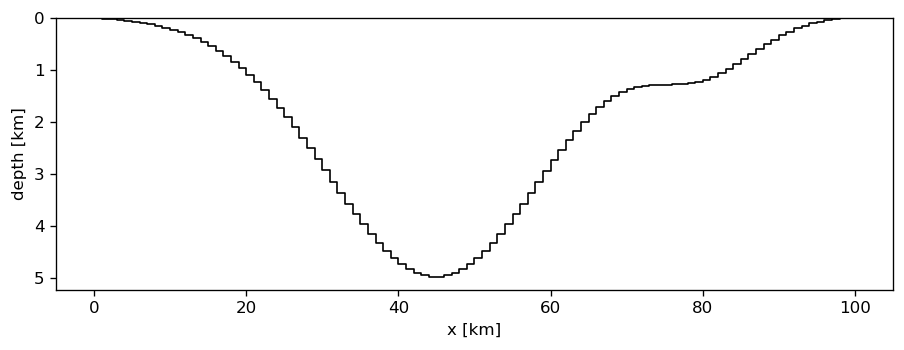

In [4]:
cc.plot_prisms(depths, basin_boundaries)

Forward model some gravity data at a set of locations.

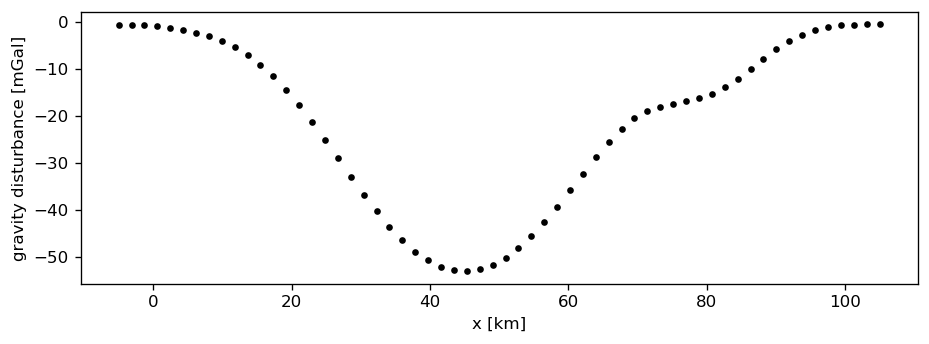

In [5]:
x = np.linspace(-5e3, 105e3, 60)
density = -300  # kg/m³
data = cc.forward_model(depths, basin_boundaries, density, x)

plt.figure(figsize=(9, 3))
plt.plot(x / 1000, data, ".k")
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

## Calculating the Jacobian matrix

The first step to most inverse problems is being able to calculate the Jacobian matrix. We'll do this for our problem by a first-order finite differences approximation. If you can get analytical derivatives, that's usually a lot better.

In [6]:
def make_jacobian(parameters, basin_boundaries, density, x):
    """
    Calculate the Jacobian matrix by finite differences.
    """
    jacobian = np.empty((x.size, parameters.size))
    step = np.zeros_like(parameters)
    delta = 10
    for j in range(jacobian.shape[1]):
        step[j] += delta
        jacobian[:, j] = (
            (
                cc.forward_model(parameters + step, basin_boundaries, density, x)
                - cc.forward_model(parameters, basin_boundaries, density, x)
            ) 
            / delta
        )
        step[j] = 0
    return jacobian

Calculate and plot an example so we can see what this matrix looks like. We'll use a parameter vector with constant depths at first.

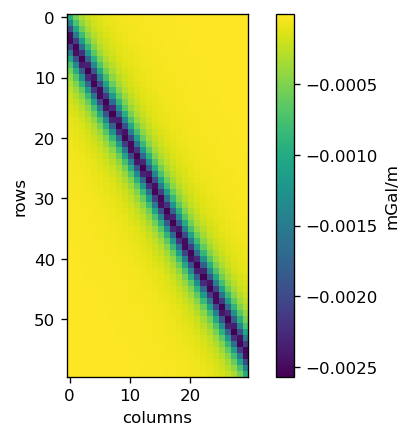

In [7]:
parameters = np.zeros(30) + 5000

jacobian = make_jacobian(parameters, basin_boundaries, density, x)

plt.figure()
plt.imshow(jacobian)
plt.colorbar(label="mGal/m")
plt.xlabel("columns")
plt.ylabel("rows")
plt.show()

## Solve the inverse problem 

Now that we have a way of forward modelling and calculating the Jacobian matrix, we can implement the Gauss-Newton method for solving the non-linear inverse problem. The function below takes the input data, model configuration, and an initial estimate and outputs the estimated parameters and a list with the goal function value per iteration. 

In [8]:
def basin2d_inversion(x, data, basin_boundaries, density, initial, max_iterations=10):
    """
    Solve the inverse problem using the Gauss-Newton method.
    """
    parameters = initial.astype(np.float64).copy() 
    predicted = cc.forward_model(parameters, basin_boundaries, density, x)
    residuals = data - predicted
    goal_function = [np.linalg.norm(residuals)**2]
    for i in range(max_iterations):       
        jacobian = make_jacobian(parameters, basin_boundaries, density, x)
        hessian = jacobian.T @ jacobian
        gradient = jacobian.T @ residuals
        deltap = np.linalg.solve(hessian, gradient)
        new_parameters = parameters + deltap
        predicted = cc.forward_model(new_parameters, basin_boundaries, density, x)
        residuals = data - predicted
        current_goal = np.linalg.norm(residuals)**2
        if current_goal > goal_function[-1]:
            break
        parameters = new_parameters
        goal_function.append(current_goal)
    return parameters, goal_function

Now we can use this function to invert our synthetic data.

In [9]:
estimated, goal_function = basin2d_inversion(
    x, data, basin_boundaries, density, initial=np.full(30, 1000),
)
predicted = cc.forward_model(estimated, basin_boundaries, density, x)

Plot the observed vs predicted data so we can inspect the fit.

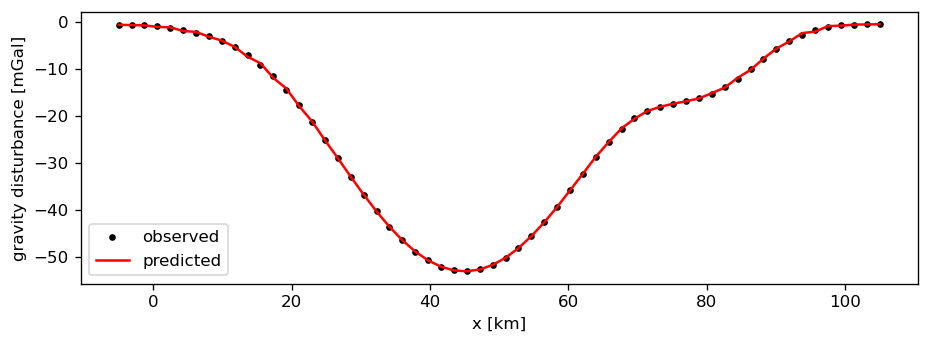

In [10]:
plt.figure(figsize=(9, 3))
plt.plot(x / 1e3, data, ".k", label="observed")
plt.plot(x / 1e3, predicted, "-r", label='predicted')
plt.legend()
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

Look at the convergence of the method.

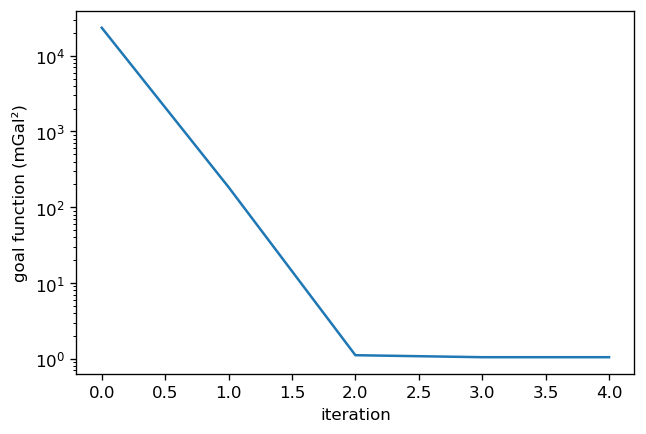

In [11]:
plt.figure()
plt.plot(goal_function)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("goal function (mGal²)")
plt.show()

And finally see if our estimate is close to the true model.

<AxesSubplot:xlabel='x [km]', ylabel='depth [km]'>

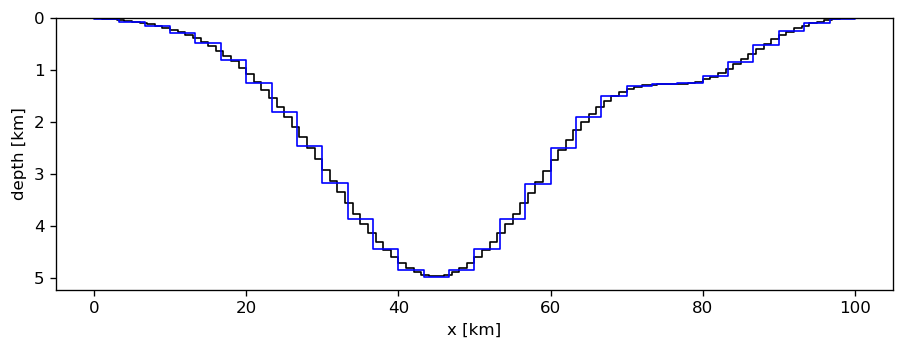

In [12]:
ax = cc.plot_prisms(depths, basin_boundaries)
cc.plot_prisms(estimated, basin_boundaries, edgecolor="blue", ax=ax)

Perfect! It seems that our inversion works well under these conditions (this initial estimate and no noise in the data). **Now let's break it!**

## **Your turn**

**Add pseudo-random noise to the data using `np.random.normal` function and investigate the effect this has on the inversion results.** A typical gravity survey has accuracy in between 0.5-1 mGal. 

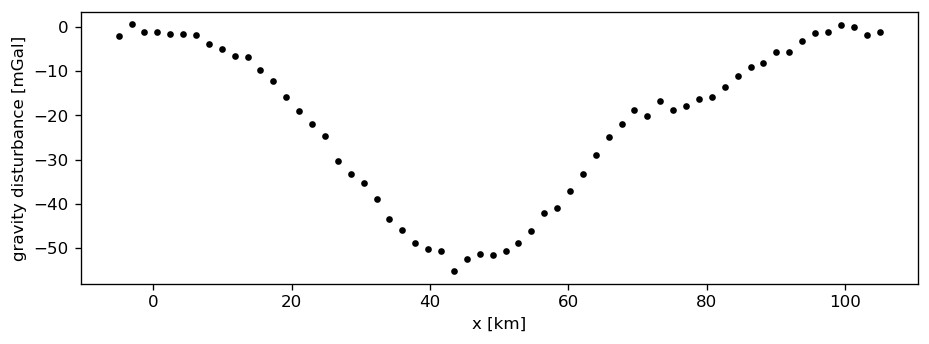

In [13]:
noise = np.random.normal(loc=0, scale=1, size=data.size)
noisy_data = data + noise

plt.figure(figsize=(9, 3))
plt.plot(x / 1000, noisy_data, ".k")
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

Run the inversion again with the noisy data.

In [14]:
estimated, goal_function = basin2d_inversion(
    x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000),
)
predicted = cc.forward_model(estimated, basin_boundaries, density, x)

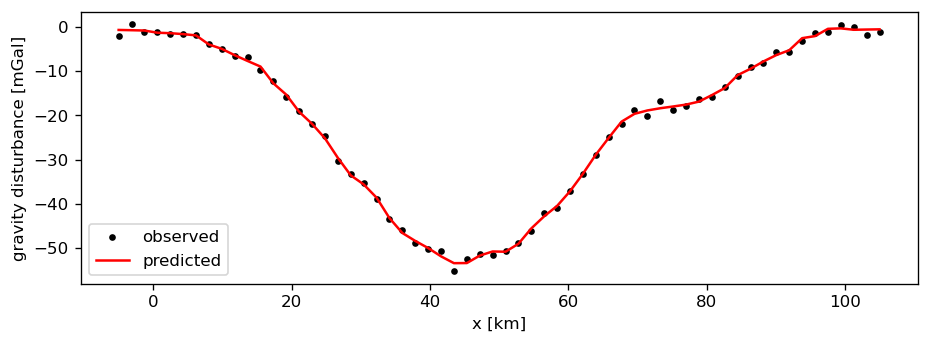

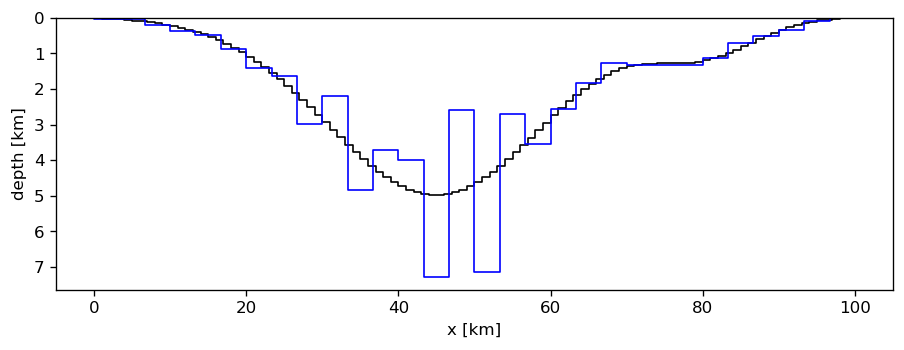

In [15]:
plt.figure(figsize=(9, 3))
plt.plot(x / 1e3, noisy_data, ".k", label="observed")
plt.plot(x / 1e3, predicted, "-r", label='predicted')
plt.legend()
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")

ax = cc.plot_prisms(depths, basin_boundaries)
cc.plot_prisms(estimated, basin_boundaries, edgecolor="blue", ax=ax)

plt.show()

Wow! It seems that **small perturbations of the data led to large changes in the estimated model**. This is characteristic of an **unstable inverse problem**.

We can go one step further and run several of these inversion in a loop for different random noise realizations.

In [16]:
estimates = []
for i in range(5):
    noise = np.random.normal(loc=0, scale=1, size=data.size)
    noisy_data = data + noise
    estimated, goal_function = basin2d_inversion(
        x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000),
    )
    estimates.append(estimated)

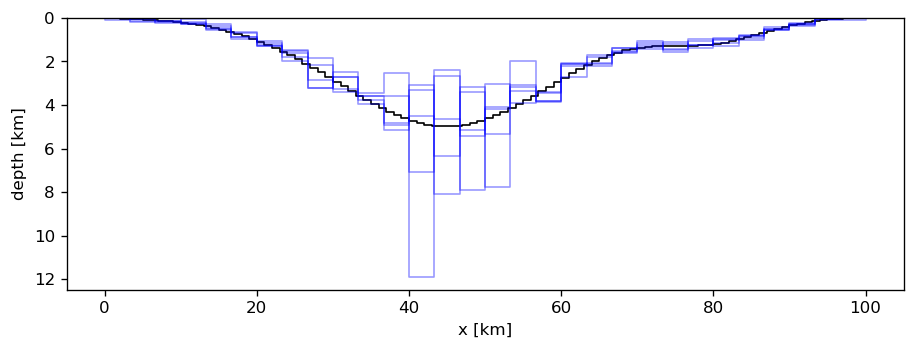

In [17]:
ax = cc.plot_prisms(depths, basin_boundaries)
for estimated in estimates:
    cc.plot_prisms(estimated, basin_boundaries, edgecolor="#0000ff66", ax=ax)

## **Question time!**

**Why does the inversion become more unstable for the deeper portions of the model?**

Hint: It's related to the physics of the forward modelling and the Jacobian matrix.

## Regularization to the rescue

To deal with the instability issues we encountered, we will apply **first-order Tikhonov regularization** (aka "smoothness"). 

First thing we need to do is create the finite difference matrix $\bar{\bar{R}}$.

In [18]:
def finite_difference_matrix(nparams):
    """
    Create the finite difference matrix for regularization.
    """
    fdmatrix = np.zeros((nparams - 1, nparams))
    for i in range(fdmatrix.shape[0]):
        fdmatrix[i, i] = -1
        fdmatrix[i, i + 1] = 1
    return fdmatrix

In [19]:
finite_difference_matrix(10)

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.]])

Now we can use this to make a new inversion function with smoothness.

In [20]:
def basin2d_smooth_inversion(x, data, basin_boundaries, density, initial, smoothness, max_iterations=10):
    """
    Solve the regularized inverse problem using the Gauss-Newton method.
    """
    parameters = initial.astype(np.float64).copy() 
    predicted = cc.forward_model(parameters, basin_boundaries, density, x)
    residuals = data - predicted
    goal_function = [np.linalg.norm(residuals)**2]
    fdmatrix = finite_difference_matrix(parameters.size)
    for i in range(max_iterations):       
        jacobian = make_jacobian(parameters, basin_boundaries, density, x)
        hessian = jacobian.T @ jacobian + smoothness * fdmatrix.T @ fdmatrix
        gradient = jacobian.T @ residuals - smoothness * fdmatrix.T @ fdmatrix @ parameters
        deltap = np.linalg.solve(hessian, gradient)
        new_parameters = parameters + deltap
        predicted = cc.forward_model(new_parameters, basin_boundaries, density, x)
        residuals = data - predicted
        current_goal = np.linalg.norm(residuals)**2
        if current_goal > goal_function[-1]:
            break
        parameters = new_parameters
        goal_function.append(current_goal)
    return parameters, goal_function

Now we check if it works on our noisy data.

In [21]:
estimates = []
for i in range(5):
    noise = np.random.normal(loc=0, scale=1, size=data.size)
    noisy_data = data + noise
    estimated, goal_function = basin2d_smooth_inversion(
        x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000), smoothness=1e-5
    )
    estimates.append(estimated)

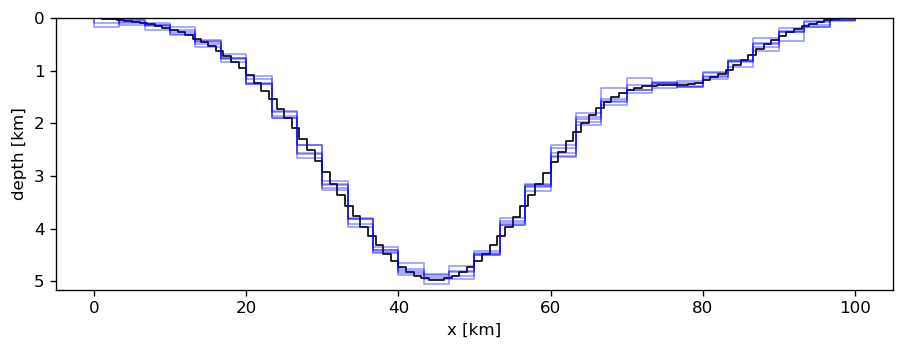

In [22]:
ax = cc.plot_prisms(depths, basin_boundaries)
for estimated in estimates:
    cc.plot_prisms(estimated, basin_boundaries, edgecolor="#0000ff66", ax=ax)

## **Question time!**

**What happens when the regularization paramater is extremely high?** Try to predict what the answer would be and then execute the code to check your reasoning.

Hint: what is the smoothest possible model?

## **Your turn**

**Can our regularized model recover a non-smooth geometry?** For example, real sedimentary basins often have [faults](https://en.wikipedia.org/wiki/Fault_(geology)) running through them, causing sharp jumps in the sediment thickness (up or down). 

To answer this question:

1. Use the modified model depths below (the `depths` array) that introduce a shift up or down by 1-2 km in a section of the model of about 5-10 km.
2. Generate new noisy data with this new model
3. Invert the noisy data and try to find a model that:
   1. Fits the data
   2. Is stable (doesn't vary much if we change the noise)
   3. Recovers the sharp boundary

In [23]:
fault_model = np.copy(depths)
fault_model[45:55] -= 2000

<AxesSubplot:xlabel='x [km]', ylabel='depth [km]'>

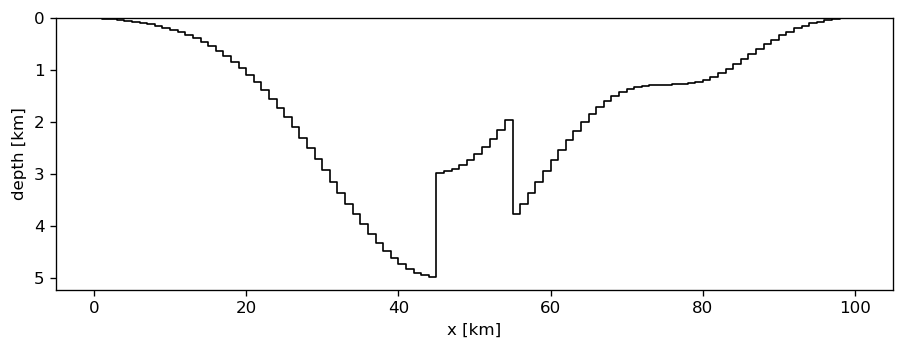

In [24]:
cc.plot_prisms(fault_model, basin_boundaries)

Now fill out the rest of the code below!

In [25]:
fault_data = cc.forward_model(fault_model, basin_boundaries, density, x)

In [26]:
estimates = []
for i in range(5):
    noise = np.random.normal(loc=0, scale=1, size=data.size)
    noisy_data = fault_data + noise
    estimated, goal_function = basin2d_smooth_inversion(
        x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000), smoothness=1e-5
    )
    estimates.append(estimated)

(5.5, 0.0)

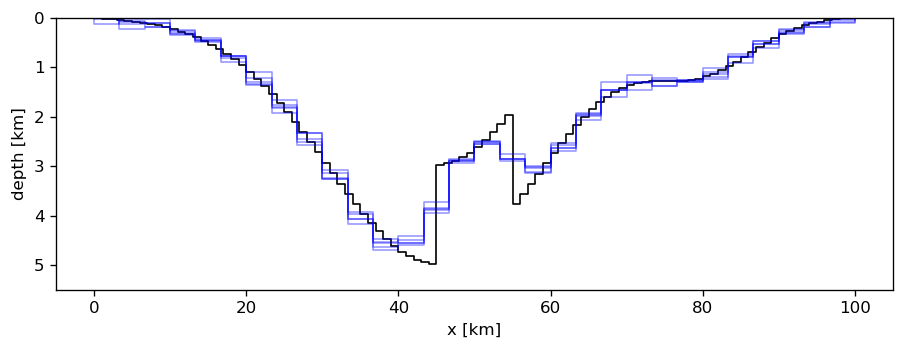

In [27]:
ax = cc.plot_prisms(fault_model, basin_boundaries)
for estimated in estimates:
    cc.plot_prisms(estimated, basin_boundaries, edgecolor="#0000ff66", ax=ax)
ax.set_ylim(5.5, 0)

## **Question time!**

**What would happen if we used a "sharpness" regularization?** Would we be able to recover the faults? What about the smoother parts of the model? 

One type of sharpness regularization is called "total-variation regularization" and it [has been used for this problem in the past](https://doi.org/10.1190/1.3524286).

## Extra thinking points

* What happens if we get the density wrong?
* What are the sources of uncertainty in our final solution? Is it just the noise in the data?
* How much does the solution depend on the inital estimate?

## **Bonus:** Optimizing code

The code we wrote is not the greatest and it does take a while to run even for these really small 2D problems. There are ways in which we can make the code fast. But before we do any of that, **we need to know where our code spends most of its time**. Otherwise, we could spend hours optimizing a part of the code that is already really fast.

This can be done with tools called **profilers**, which measure the time spent in each function of your code. This is also why its very important to **break up your code into functions**. In a Jupyter notebook, you can run the standard Python profiler by using the `%%prun` cell magic:

In [28]:
%%prun 
basin2d_smooth_inversion(
        x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000), smoothness=1e-5
)

         97909 function calls (96363 primitive calls) in 2.462 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    73440    1.560    0.000    1.560    0.000 cheatcodes.py:132(kernel)
     9180    0.698    0.000    2.258    0.000 cheatcodes.py:98(prism_gravity)
      306    0.051    0.000    2.453    0.008 cheatcodes.py:84(forward_model)
      306    0.021    0.000    0.101    0.000 function_base.py:23(linspace)
 2175/629    0.018    0.000    0.134    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      306    0.007    0.000    0.021    0.000 fromnumeric.py:69(_wrapreduction)
      311    0.006    0.000    0.023    0.000 numeric.py:76(zeros_like)
      306    0.006    0.000    0.016    0.000 numerictypes.py:358(issubdtype)
      612    0.006    0.000    0.009    0.000 numerictypes.py:284(issubclass_)
      955    0.004    0.000    0.004    0.000 {built-in method builtins.issubclass}
      311  

The `tottime` column is the amount of time spent on the function itself (not counting functions called inside it) and `cumtime` is the total time spent in the function, including function calls inside it. 

We can see from the profiling that the majority of the computation is spend in forward modelling, in particular for building the Jacobian. So if we can optimize `make_jacobian` that will have the biggest impact on performance of all.

To start let's measure the computation time of `make_jacobian` with the `%%timeit` magic:

In [29]:
%%timeit
make_jacobian(np.full(30, 1000), basin_boundaries, density, x)

252 ms ± 8.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Alright, now we can try to do better.

For many of these problems, the biggest return on investment is **not** parallelization or going to C/Fortran. **The largest improvements come from better maths/physics**. Here, we can take advantage of potential-field theory to cut down on the computation time of the Jacobian. 

We'll use the fact that the difference in gravity values produced by two models is the same as the gravity value produced by the difference in the models. Meaning that $\delta g = g(m_1) - g(m_2) = g(m_1 - m_2)$. This way, we can reduce by more than half the number of forward modelling operations we do in the finite-difference computations.

So instead of calculating the entire basin model with and without a small step in a single parameter, we can only calculate the effect of that small step.

In [30]:
def make_jacobian_fast(parameters, basin_boundaries, density, x):
    """
    Calculate the Jacobian matrix by finite differences.
    """
    jacobian = np.empty((x.size, parameters.size))
    delta = 10
    boundaries = cc.prism_boundaries(parameters, basin_boundaries)
    for j in range(jacobian.shape[1]):
        jacobian[:, j] = (
            (
                # Replace with a single forward modelling of a single prism
                cc.prism_gravity(x, boundaries[j], boundaries[j + 1], parameters[j], parameters[j] + delta, density)
            ) 
            / delta
        )
    return jacobian

First, we check if the results are still correct.

In [31]:
np.allclose(
    make_jacobian(np.full(30, 1000), basin_boundaries, density, x),
    make_jacobian_fast(np.full(30, 1000), basin_boundaries, density, x)
)

True

Now we can measure the time again:

In [32]:
%%timeit
make_jacobian_fast(np.full(30, 1000), basin_boundaries, density, x)

4.63 ms ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This one change gave use 2 orders of magnitude improvement in the function that makes up most of the computation time. **Now that is time well spent!**

We can measure how much of a difference this makes for the inversion as a whole by making a new function with our fast Jacobian matrix calculation.

In [33]:
def fast_basin2d_smooth_inversion(x, data, basin_boundaries, density, initial, smoothness, max_iterations=10):
    """
    Solve the regularized inverse problem using the Gauss-Newton method.
    """
    parameters = initial.astype(np.float64).copy() 
    predicted = cc.forward_model(parameters, basin_boundaries, density, x)
    residuals = data - predicted
    goal_function = [np.linalg.norm(residuals)**2]
    fdmatrix = finite_difference_matrix(parameters.size)
    for i in range(max_iterations):       
        # Swap out the slow jacobian for the fast one
        jacobian = make_jacobian_fast(parameters, basin_boundaries, density, x)
        hessian = jacobian.T @ jacobian + smoothness * fdmatrix.T @ fdmatrix
        gradient = jacobian.T @ residuals - smoothness * fdmatrix.T @ fdmatrix @ parameters
        deltap = np.linalg.solve(hessian, gradient)
        new_parameters = parameters + deltap
        predicted = cc.forward_model(new_parameters, basin_boundaries, density, x)
        residuals = data - predicted
        current_goal = np.linalg.norm(residuals)**2
        if current_goal > goal_function[-1]:
            break
        parameters = new_parameters
        goal_function.append(current_goal)
    return parameters, goal_function

And now we can measure the computation time for both.

In [34]:
%%timeit 
basin2d_smooth_inversion(
        x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000), smoothness=1e-5
)

1.92 s ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit 
fast_basin2d_smooth_inversion(
        x, noisy_data, basin_boundaries, density, initial=np.full(30, 1000), smoothness=1e-5
)

175 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**We changed 3 lines of code and achived a factor of 10 speedup.** Again, this could only be done because we first profiled the code and then focused on finding a fundamentally better way of calculating. 